<h2> Figure 3, upper middle plot </h2>

In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot 

import csv
import sys

In [2]:
steps = 2000 # number of training steps
iteration = 10 # number of iterations (iid runs)
d = 1 #  dimension of the distributions
mb_size = 4000  # batch size
N = [5000, 10000, 20000, 50000, 100000, 150000] # sample size range
w = 0.2 # subpopulation ratio
lam_gp = 0.1  # gradient penalty constant: \lambda_{gp}

print(steps)
print(iteration)
print(d)
print(mb_size)
print(w)


2000
10
1
4000
0.2


In [3]:
# hyperparameters
if d==2:
    layers = [d, 16, 16, 8, 1]
elif d==10:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 64, 64, 32, 1]
elif d==1:                     
    layers = [d, 16, 16, 8, 1]

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  #h = [x, x**2] and fix D_w dimension
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out =  tf.add(tf.matmul(h, W), b)   # unbounded!

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(N), iteration)) 
RD_exact_N =  np.zeros(shape= len(N))


In [6]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, n in enumerate(N): 
    
    print('j=', j)
    print('n=', n)
    
    # load data
    fname = 'data/mu2_1_arch_16/N'+str(n)+'_a_0.5_and_3.7/input_data/GMM_d_1_'
    data = scipy.io.loadmat(fname + 'data_'+str(w)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(w)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_N[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    
    # Gradient Penalty
    alpha_gp = tf.random_uniform(shape=[mb_size,1], minval=0., maxval=1.)
    interpolates = X + (alpha_gp*(Y - X)) 
    gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]  
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1])) 
    gradient_penalty = tf.reduce_mean(tf.math.maximum(tf.zeros([slopes.shape[0]], dtype=tf.float32) ,(slopes-1.))**2)  # one-sided penalty  (Lipschitz with k=1)

    total_loss = D_loss + lam_gp*gradient_penalty # + because we minimize in optimizer
    


    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_GMM_BS_Lip_plots_over_N/'):
        os.makedirs('data/out_GMM_BS_Lip_plots_over_N/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_GMM_BS_Lip_plots_over_N/cgan_Dloss' + str(j) + 'w_' + str(w) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
n= 5000
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration: 0
Iter: 0
Renyi divergence: [-0.00017588]

Iter: 1000
Renyi divergence: [0.07050252]

Iteration: 1
Iter: 0
Renyi divergence: [9.657408e-05]

Iter: 1000
Renyi divergence: [0.05026603]

Iteration: 2
Iter: 0
Renyi divergence: [-4.854478e-05]

Iter: 1000
Renyi divergence: [0.06030422]

Iteration: 3
Iter: 0
Renyi divergence: [6.0469378e-05]

Iter: 1000
Renyi divergence: [0.04921874]

Iteration: 4
Iter: 0
Renyi divergence: [-1.7877377e-05]

Iter: 1000
Renyi divergence: [0.0416275]

Iteration: 5
Iter: 0
Renyi divergence: [2.3995817e-05]

Iter: 1000
Renyi divergence: [0.0490216]

Iteration: 6
Iter: 0
Renyi divergence: [2.5071466e-05]

Iter: 1000
Renyi divergence: [0.05656005]

Iteration: 7
Iter: 0
Renyi divergence: [-2.7118833e-05]

Iter: 1000
Renyi divergence: [0.06215036]

Iteration: 8
Iter: 0
Renyi divergence: [4.985265e-05]

Iter: 1000
Renyi divergence: [0.04783458]

Iterat

In [7]:
   

with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_Lip_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


In [8]:
data_back = D_loss_vals


Text(0, 0.5, 'divergence')

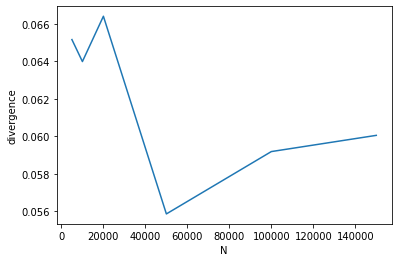

In [9]:
# Plot RD vs N
#======================
fig = plt.figure()
#x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
plt.plot(N, D_loss_vals[:,0])
plt.xlabel('N')
plt.ylabel('divergence')

(0.045, 0.09)

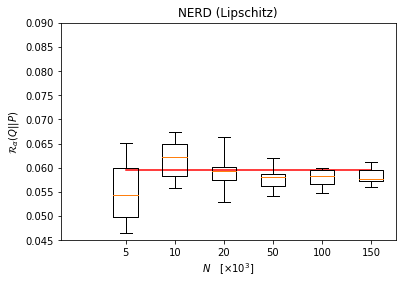

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Lipschitz)')
ax1.plot(np.arange(1,len(N)+1), RD_exact_N[:],'r', 'LineWidth', 2 );
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[5,10,20,50,100,150], whis=10)
plt.xlabel(r'$N\quad [\times 10^3]$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.045, 0.09)


In [11]:
print('program terminated succesfully')

program terminated succesfully
